# Part A: Stock Price Forecasting

## 0. Outline of the task
1. Check for duplicative data
2. Check for missing data
3. Fill missing data
4. Check for stationarity with ADF test
5. Transform non-stationary series to stationary series
6. Check for white noise with Ljung-Box test and ACF plot
7. View distribution of series with ETS decomposition
8. Initialise training and testing data
9. Model selection and hypertuning parameters
10. Model forecasting

## 1. Import Libraries

In [1]:
# ignore harmless warnings
import warnings
warnings.simplefilter("ignore", UserWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse

## 2. Load Dataset

In [2]:
# load the data
df = pd.read_csv('Data/CA2-Stock-Price-Data.csv', index_col='Date', parse_dates=True)
df

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-22,174.789993,129.119995,33.250000
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998


In [3]:
# check if index is datetime object
print(f'Number of rows: {len(df.index)}')
df.index

Number of rows: 1257


DatetimeIndex(['2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04',
               '2018-10-05', '2018-10-08', '2018-10-09', '2018-10-10',
               '2018-10-11', '2018-10-12',
               ...
               '2023-09-15', '2023-09-18', '2023-09-19', '2023-09-20',
               '2023-09-21', '2023-09-22', '2023-09-25', '2023-09-26',
               '2023-09-27', '2023-09-28'],
              dtype='datetime64[ns]', name='Date', length=1257, freq=None)

## 3. Data Preprocessing

### (a) Check for duplicates

In [4]:
# check for duplicates
df[df.duplicated(keep=False)]

,Apple,Amazon,DBS
Date,,,


From the output above, we can conclude that there is no duplicative data

### (b) Add missing dates

As some dates are missing (e.g. weekends and public holidays where the stock market is closed), we need to add them to the dataset

In [5]:
# add missing dates into a separate dataset
datetime_df = pd.DataFrame(index=pd.date_range(start=df.index[0], end=df.index[(len(df)) - 1], freq='D'))
df = datetime_df.join(df, how='left')
df

,Apple,Amazon,DBS
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-24,NaN,NaN,NaN
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998
2023-09-27,170.429993,125.980003,33.430000


In [6]:
# check if index is datetime object
print(f'Number of rows: {len(df.index)}')
df.index

Number of rows: 1824


DatetimeIndex(['2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04',
               '2018-10-05', '2018-10-06', '2018-10-07', '2018-10-08',
               '2018-10-09', '2018-10-10',
               ...
               '2023-09-19', '2023-09-20', '2023-09-21', '2023-09-22',
               '2023-09-23', '2023-09-24', '2023-09-25', '2023-09-26',
               '2023-09-27', '2023-09-28'],
              dtype='datetime64[ns]', length=1824, freq='D')

As the number of rows has increased from 1257 to 1824, we can conclude that we have successfully added the missing dates

### (c) Check for missing values

In [7]:
# check for missing values
print(f'Missing values:\n{df.isnull().sum()}')

Missing values:
Apple     567
Amazon    567
DBS       567
dtype: int64


### (d) Fill missing values

In [8]:
# fill missing values
df = df.ffill()
df

,Apple,Amazon,DBS
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-24,174.789993,129.119995,33.250000
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998
2023-09-27,170.429993,125.980003,33.430000


In [9]:
# check if theres still missing values
df.isnull().sum()

Apple     0
Amazon    0
DBS       0
dtype: int64

From the output above, we can tell that there is no more missing values, meaning that we have successfully filled in the missing values

### (e) Check for stationarity (ADF Test)

In [10]:
# ADF test for each series
for col in df.columns:
    adf_df = adfuller(df[col])
    p_value_df = adf_df[1]
    
    print(f'p-value of {col}: {p_value_df}')

p-value of Apple: 0.7591233096947594
p-value of Amazon: 0.49583495166235525
p-value of DBS: 0.6438876920102604


* H0 : the series is non-stationary
* H1 : the series is stationary

As each series' p-value > 0.05, they are non-stationary (fail to reject H0)
Hence, we need to convert these non-stationary time series into stationary by differencing

### (f) Visualise series

Before we use differencing to transform the series, we first visualise the series to see if there are any trends or seasonality

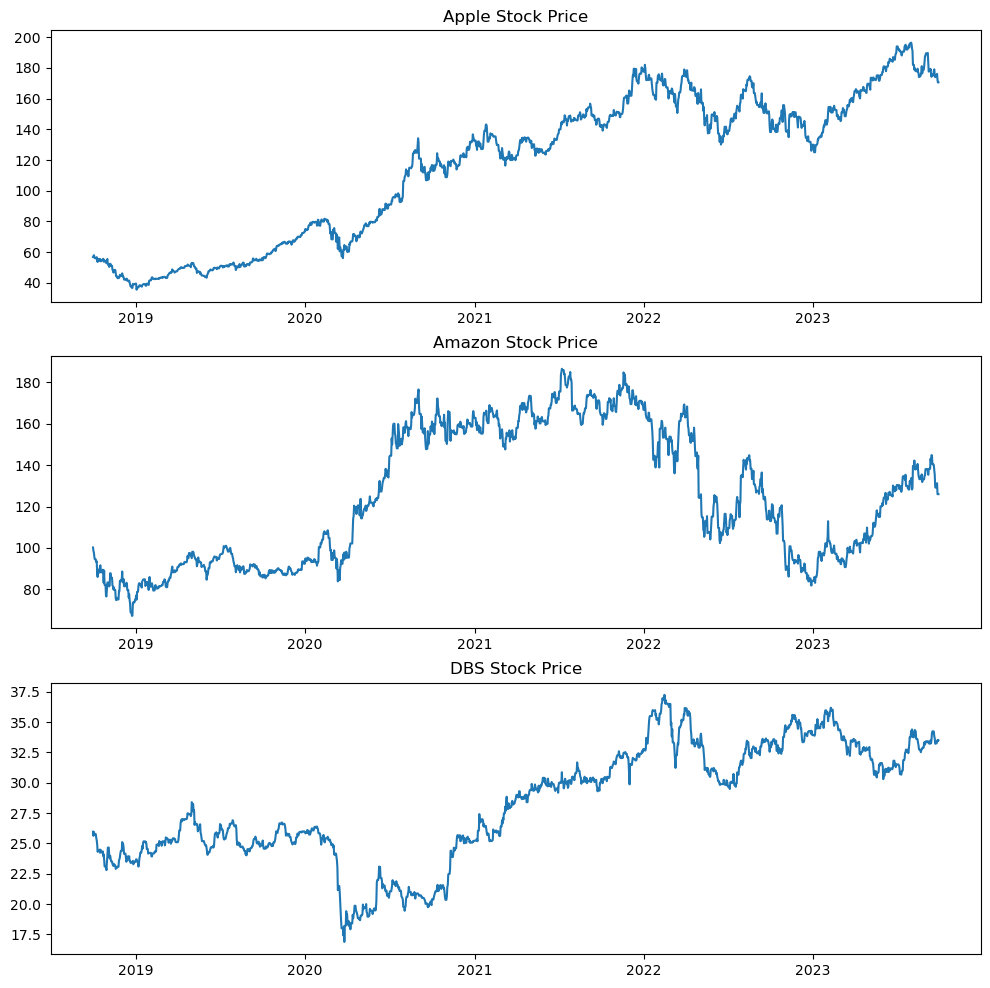

In [11]:
# plot each series to view variance
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

for i, col in enumerate(df.columns):
    ax[i].plot(df[col])
    ax[i].set_title(f'{col} Stock Price')

plt.show()

Since the variance and mean of each series is not constant, we need to transform the series using log and/or differencing transformation

### (g) Transform series

Initially I thought of using returns (percentage change of current and previous day's price). However, I realised that the returns do not necessarily have a constant variance, so I decided to use log and/or differencing for each series

#### (i) Apple

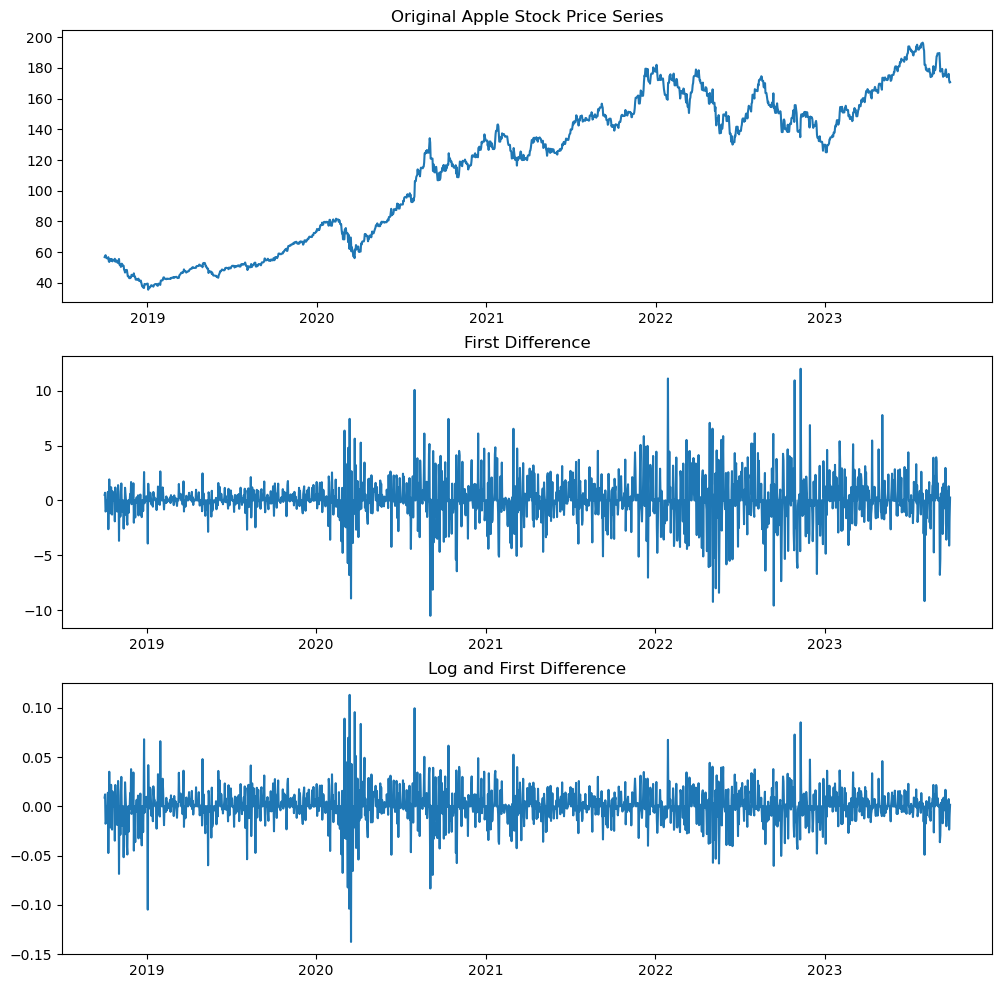

In [12]:
# Check if the series is stationary and transform the series if they are not
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(df['Apple'])
ax[0].set_title('Original Apple Stock Price Series')

apple_diff = df['Apple'].diff()
apple_diff.name = 'apple_diff'
ax[1].plot(apple_diff)
ax[1].set_title('First Difference')

apple_log_diff = np.log(df['Apple']).diff()
apple_log_diff.name = 'apple_log_diff'
ax[2].plot(apple_log_diff)
ax[2].set_title('Log and First Difference')

plt.show()

#### (ii) Amazon

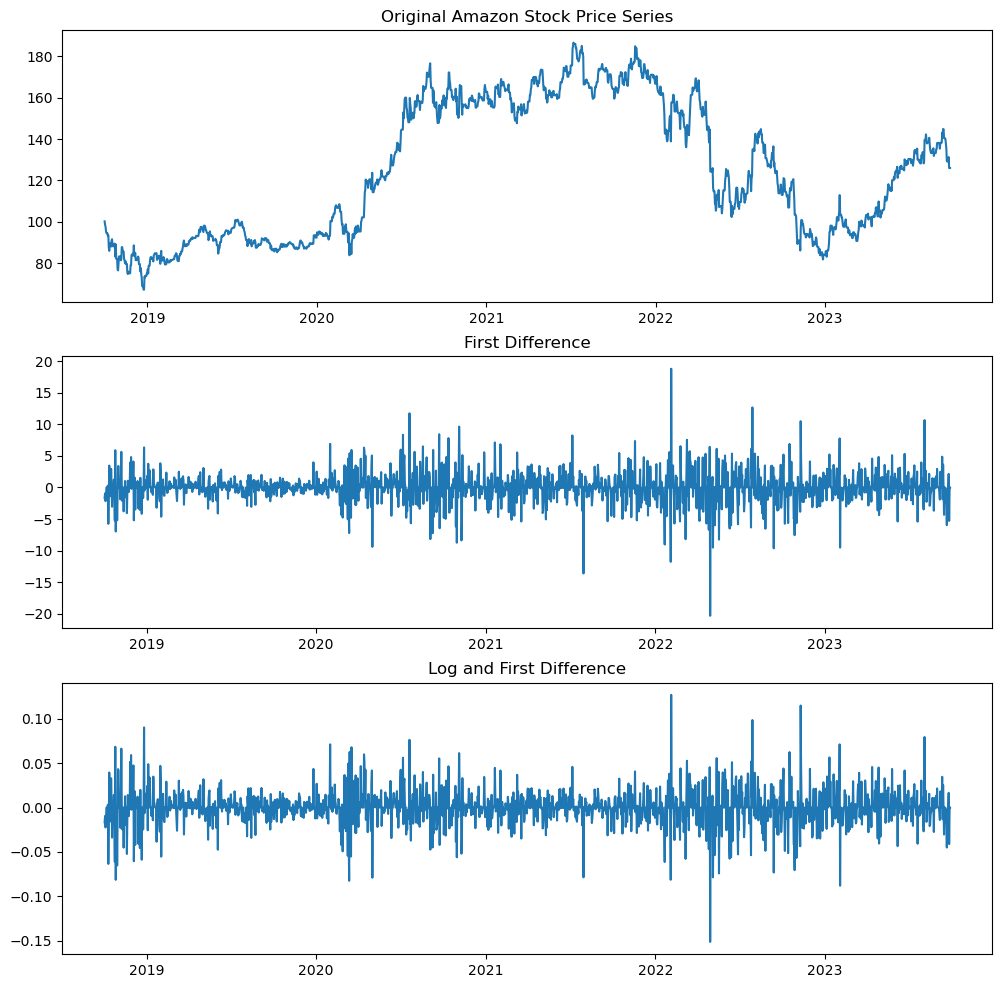

In [13]:
# Check if the series is stationary and transform the series if they are not
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(df['Amazon'])
ax[0].set_title('Original Amazon Stock Price Series')

amazon_diff = df['Amazon'].diff()
amazon_diff.name = 'amazon_diff'
ax[1].plot(amazon_diff)
ax[1].set_title('First Difference')

amazon_log_diff = np.log(df['Amazon']).diff()
amazon_log_diff.name = 'amazon_log_diff'
ax[2].plot(amazon_log_diff)
ax[2].set_title('Log and First Difference')

plt.show()

#### (iii) DBS

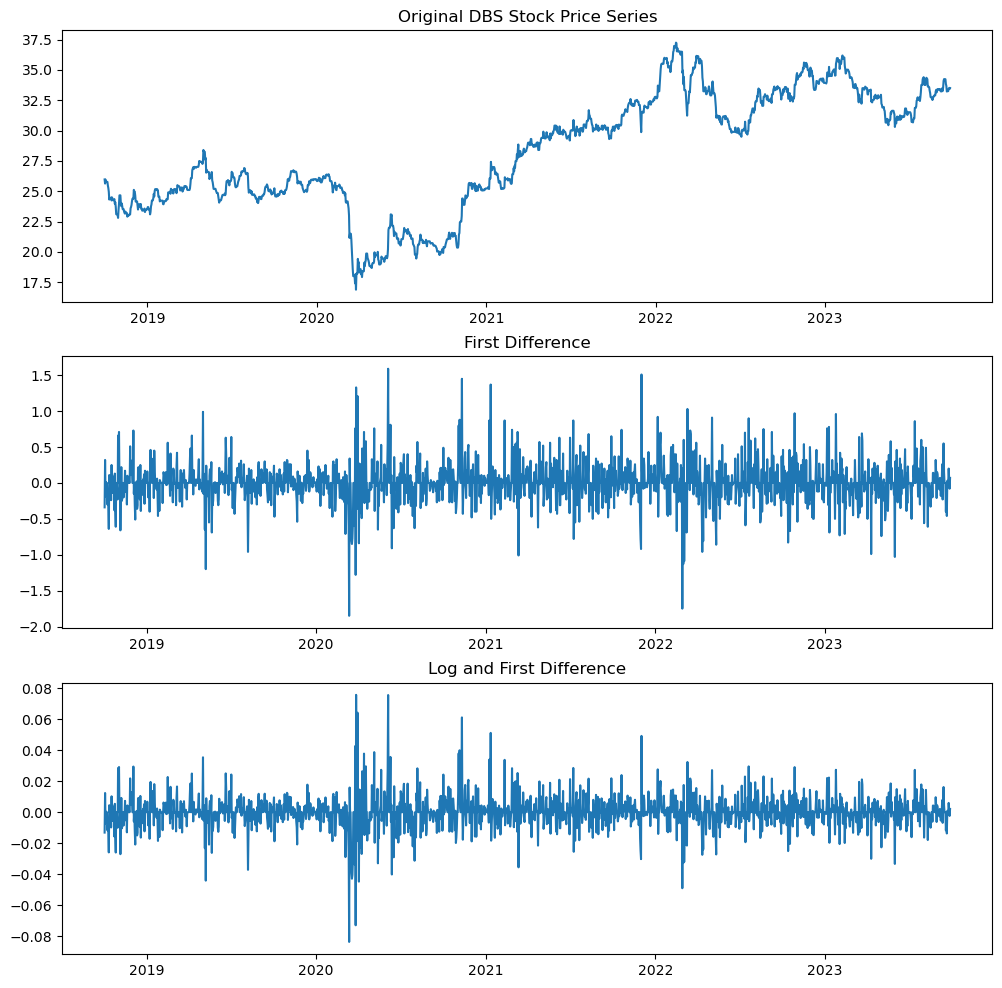

In [14]:
# Check if the series is stationary and transform the series if they are not
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(df['DBS'])
ax[0].set_title('Original DBS Stock Price Series')

dbs_diff = df['DBS'].diff()
dbs_diff.name = 'dbs_diff'
ax[1].plot(dbs_diff)
ax[1].set_title('First Difference')

dbs_log_diff = np.log(df['DBS']).diff()
dbs_log_diff.name = 'dbs_log_diff'
ax[2].plot(dbs_log_diff)
ax[2].set_title('Log and First Difference')

plt.show()

As the first difference series and the log and first difference for each series look very similar, we will use ADF test to check whether they are stationary series and which has a lower p-value

### (h) Check for stationarity (ADF Test)

In [15]:
# ADF test for each series
scores = []

# print out scores
for series in [apple_diff, apple_log_diff, amazon_diff, amazon_log_diff, dbs_diff, dbs_log_diff]:
    adf_df = adfuller(series.dropna())
    p_value_df = adf_df[1]
    scores.append((series.name, p_value_df))
    print(f'p-value of {series.name}: {p_value_df}')

p-value of apple_diff: 3.801575106200866e-15
p-value of apple_log_diff: 6.880735259652761e-14
p-value of amazon_diff: 0.0
p-value of amazon_log_diff: 0.0
p-value of dbs_diff: 3.895165830610594e-24
p-value of dbs_log_diff: 1.337841395235877e-24


* H0 : the series is non-stationary
* H1 : the series is stationary

As each series' p-value < 0.05, they are stationary (reject H0)

As each series' p-value is already very low, we will not need to second-order or higher-order difference the series

### (i) Determine which series to use

In [16]:
# determine which series to use
for i, score in enumerate(scores):
    if (i+1) % 2 == 0:  # every 2nd element 
        if score[1] < scores[i-1][1]:  # if log and first difference is better
            print(f'Should use {scores[i][0]}')
        else:
            print(f'Should use {scores[i-1][0]}')

Should use apple_diff
Should use amazon_diff
Should use dbs_log_diff


From the output above, we will use first order differencing without log transformation for Apple and Amazon and first order differencing with log transformation for DBS

In [17]:
# remove NaN values for each series
apple_diff = apple_diff.dropna()
amazon_diff = amazon_diff.dropna()
dbs_log_diff = dbs_log_diff.dropna()

### (j) Check for white noise

#### (i) Ljung-Box Test

In [18]:
# Apply Ljung-Box test for serial correlations up to lag 20
for series in [apple_diff, amazon_diff, dbs_log_diff]:
    result = acorr_ljungbox(series, lags=[20], return_df=True)

    print(f'Ljung-Box test for {series.name}')
    print(result.iloc[0])
    print()

Ljung-Box test for apple_diff
lb_stat      57.694453
lb_pvalue     0.000016
Name: 20, dtype: float64

Ljung-Box test for amazon_diff
lb_stat      35.914980
lb_pvalue     0.015739
Name: 20, dtype: float64

Ljung-Box test for dbs_log_diff
lb_stat      61.955691
lb_pvalue     0.000004
Name: 20, dtype: float64



* H0 : The series has no autocorrelation (i.e. autocorrelation = 0)
* H1 : The series has autocorrelation    (i.e. autocorrelation is not = 0)

Since the p-value for the series is < 0.05, they have autocorrelations and are not white noise (reject H0)

#### (ii) ACF and PACF

##### Apple

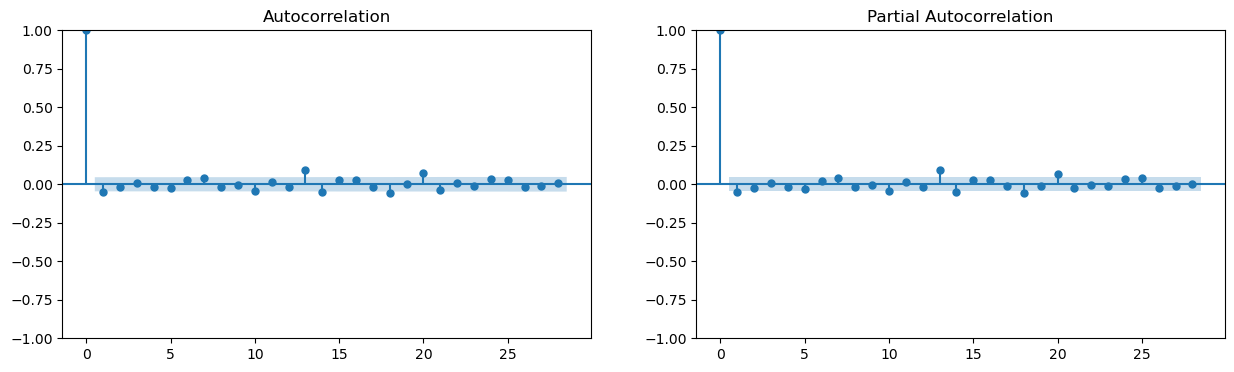

In [19]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(apple_diff, ax=axes[0], lags=28)
plot_pacf(apple_diff, ax=axes[1], lags=28)
plt.show()

##### Amazon

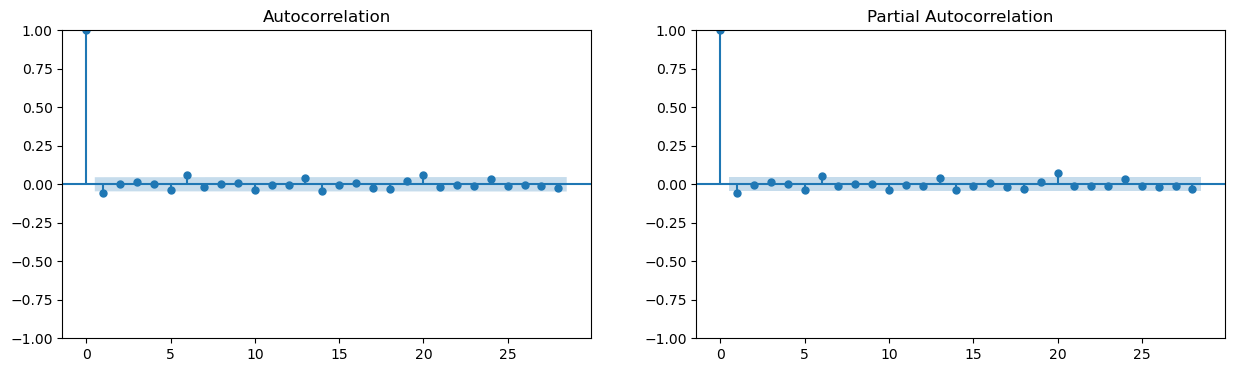

In [20]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(amazon_diff, ax=axes[0], lags=28)
plot_pacf(amazon_diff, ax=axes[1], lags=28)
plt.show()

##### DBS

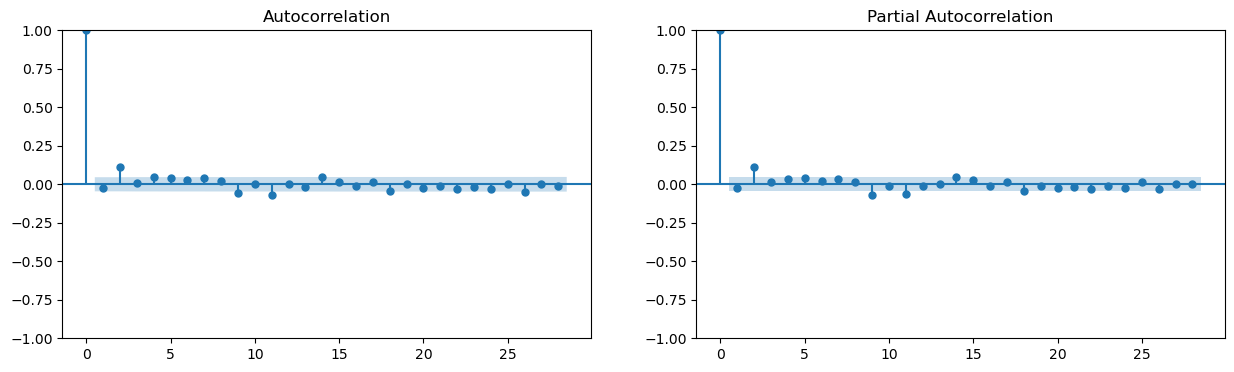

In [21]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(dbs_log_diff, ax=axes[0], lags=28)
plot_pacf(dbs_log_diff, ax=axes[1], lags=28)
plt.show()

### (k) Run ETS Decomposition

#### (i) Apple

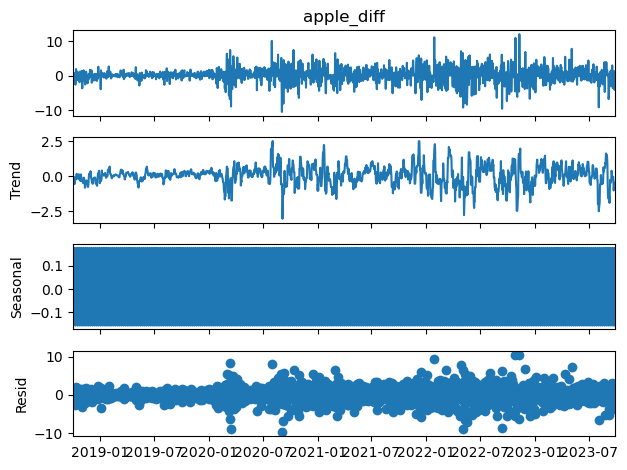

In [22]:
apple_results = seasonal_decompose(apple_diff, model='add')
apple_results.plot();  # semicolon to only show the plot once

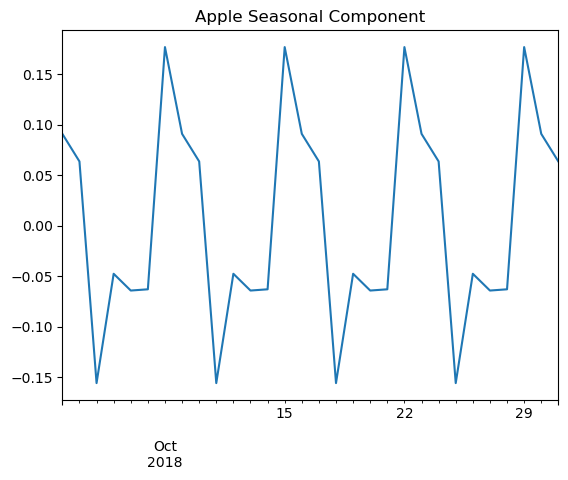

In [23]:
apple_results.seasonal.iloc[0:30].plot()  # show monthly seasonality
plt.title('Apple Seasonal Component')
plt.show()

#### (ii) Amazon

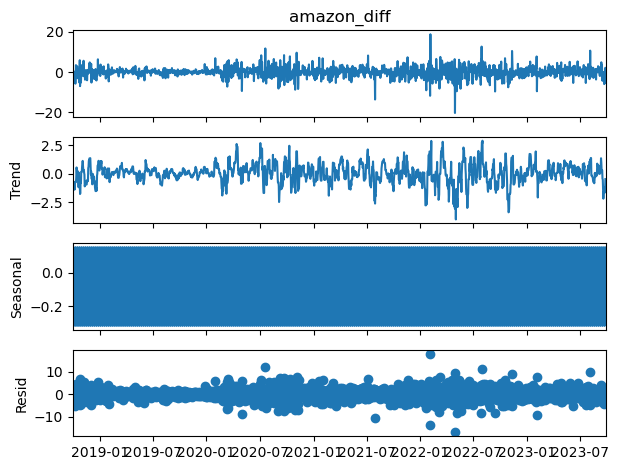

In [24]:
amazon_results = seasonal_decompose(amazon_diff, model='add')
amazon_results.plot();  # semicolon to only show the plot once

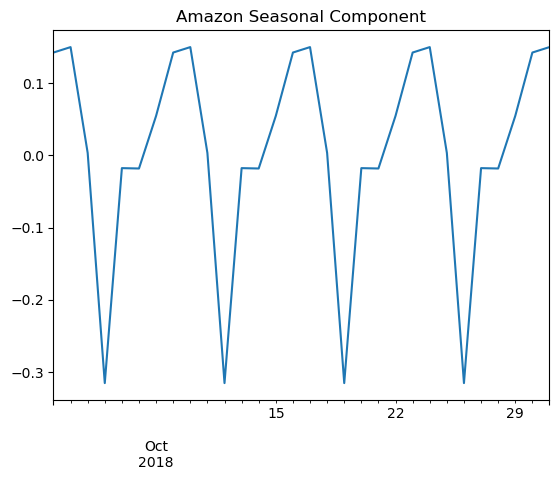

In [25]:
amazon_results.seasonal.iloc[0:30].plot()  # show monthly seasonality
plt.title('Amazon Seasonal Component')
plt.show()

#### (iii) DBS

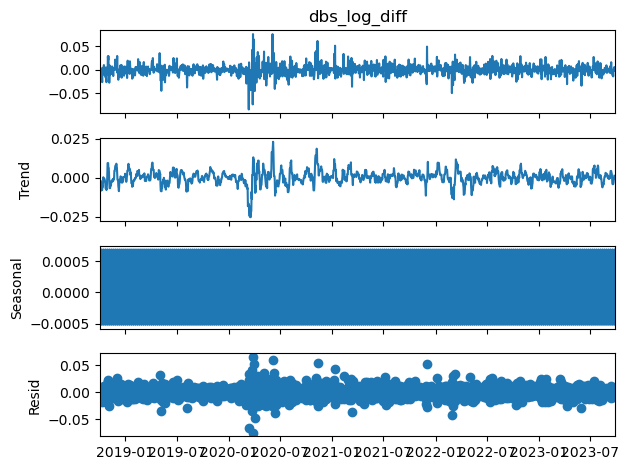

In [26]:
dbs_results = seasonal_decompose(dbs_log_diff, model='add')
dbs_results.plot();  # semicolon to only show the plot once

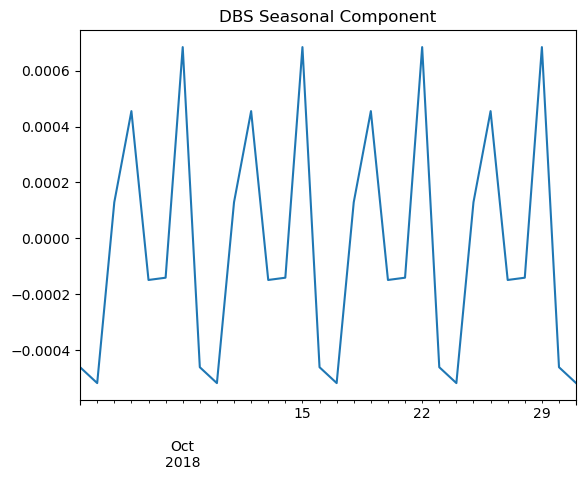

In [27]:
dbs_results.seasonal.iloc[0:30].plot()  # show monthly seasonality
plt.title('DBS Seasonal Component')
plt.show()

From all the seasonal plots shown above, we can see that one period of seasonality is 7 days. Hence, we will use a seasonal model to forecast the stock prices

## 3. Model Building

### (a) Train-Test Split

In [28]:
# set 60 days for testing
train = df.iloc[:(len(df)-60)]
test = df.iloc[-60:]

print(f'Length of whole dataset: {len(df)}')
print(f'Length of training dataset: {len(train)}')
print(f'Length of test dataset: {len(test)}')

Length of whole dataset: 1824
Length of training dataset: 1764
Length of test dataset: 60


Since the lengths of training dataset and the test dataset both add up to be equal to the length of the whole dataset, the test dataset will include the latest 60 days and the training dataset will include the rest

### (b) Model Selection

#### (i) Holt Winter's Exponential Smoothing

Root Mean Squared Error of Apple is 19.91056
Root Mean Squared Error of Amazon is 5.46066
Root Mean Squared Error of DBS is 0.65925


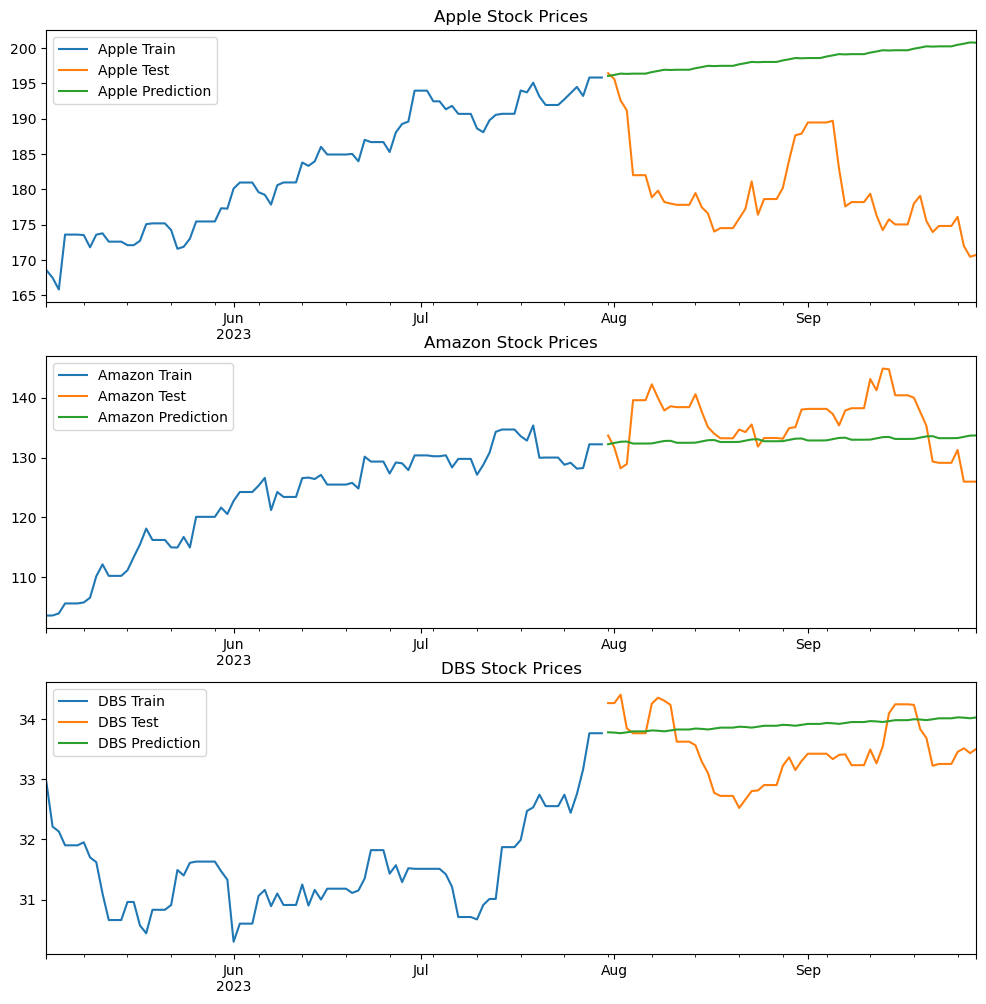

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(12,12))

# loop through each stock
for i, stock in enumerate(['Apple', 'Amazon', 'DBS']):
    model = ExponentialSmoothing(
        train[stock],
        trend='add',
        seasonal='add',
        seasonal_periods=7
    ).fit()
    # predict for 60 days ahead
    predictions = model.forecast(60)
    
    # plot for latest 90 days
    train[stock].iloc[-90:].plot(label=f'{stock} Train', ax=ax[i])
    test[stock].plot(label=f'{stock} Test', ax=ax[i])
    predictions.plot(label=f'{stock} Prediction', ax=ax[i])
    ax[i].set_title(f'{stock} Stock Prices')
    ax[i].legend()
    
    rmse_score = rmse(test[stock], predictions)
    print(f'Root Mean Squared Error of {stock} is {rmse_score:.5f}')

Although the RMSE for each stock is quite low, especially for Amazon and DBS, the model is quite simple and does not take into account for fluctuations (relatively linear line). Hence, we will not use this model to forecast prices as it is too simple

#### (ii) SARIMAX

##### Apple

In [30]:
apple_scores = []

# loop through all possible combinations of p, d, q, P, D, Q, and s
for p in range(0, 3):
    for d in range(1, 2):
        for q in range(0, 3):
            for P in range(0, 3):
                for D in range(0, 1):
                    for Q in range(0, 3):
                        apple_model = SARIMAX(
                            endog=train['Apple'],
                            exog=train[['Amazon', 'DBS']],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, 7),
                            initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
                            enforce_invertibility=False  # ignores ValueErrors
                        )
                        apple_results = apple_model.fit()

                        apple_scores.append(apple_results.aic)
                        print(f'ARIMA({p},{d},{q})({P},{D},{Q},7) - AIC: {apple_results.aic}')

print(f'Lowest AIC score: {min(apple_scores)}')

ARIMA(0,1,0)(0,0,0,7) - AIC: 6450.851361998464
ARIMA(0,1,0)(0,0,1,7) - AIC: 6542.151319639785
ARIMA(0,1,0)(0,0,2,7) - AIC: 6629.115658198895
ARIMA(0,1,0)(1,0,0,7) - AIC: 6529.303435227041
ARIMA(0,1,0)(1,0,1,7) - AIC: 6544.017481162562
ARIMA(0,1,0)(1,0,2,7) - AIC: 6630.995201683227
ARIMA(0,1,0)(2,0,0,7) - AIC: 6622.202900499866
ARIMA(0,1,0)(2,0,1,7) - AIC: 6623.99597149657
ARIMA(0,1,0)(2,0,2,7) - AIC: 6631.452846563925
ARIMA(0,1,1)(0,0,0,7) - AIC: 6462.663178333308
ARIMA(0,1,1)(0,0,1,7) - AIC: 6554.667782575863
ARIMA(0,1,1)(0,0,2,7) - AIC: 6642.0923266920745
ARIMA(0,1,1)(1,0,0,7) - AIC: 6529.030225721652
ARIMA(0,1,1)(1,0,1,7) - AIC: 6556.64406028371
ARIMA(0,1,1)(1,0,2,7) - AIC: 6644.014359813288
ARIMA(0,1,1)(2,0,0,7) - AIC: 6622.168900964876
ARIMA(0,1,1)(2,0,1,7) - AIC: 6624.0086356855245
ARIMA(0,1,1)(2,0,2,7) - AIC: 6644.626277665651
ARIMA(0,1,2)(0,0,0,7) - AIC: 6476.726012191956
ARIMA(0,1,2)(0,0,1,7) - AIC: 6569.186685702838
ARIMA(0,1,2)(0,0,2,7) - AIC: 6656.589484760401
ARIMA(0,1,2)(

In [31]:
best_apple_model = SARIMAX(
    endog=train['Apple'],
    exog=train[['Amazon', 'DBS']],
    order=(0, 1, 0),
    seasonal_order=(0, 0, 0, 7),
    initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
    enforce_invertibility=False  # ignores ValueErrors
).fit()
print(best_apple_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                 1764
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3222.426
Date:                Fri, 09 Feb 2024   AIC                           6450.851
Time:                        23:33:09   BIC                           6467.277
Sample:                    10-01-2018   HQIC                          6456.921
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Amazon         0.5330      0.007     79.470      0.000       0.520       0.546
DBS            0.1385      0.087      1.599      0.110      -0.031       0.308
sigma2         2.2445      0.033     67.814      0.0

Looking at the diagnostics of the residuals (in the bottom section):
* Ljung-Box test has high p-value => fail to reject H0 of zero autocorrelations => residuals are white-noise
* Heteroskedasticity test has high p-value => fail to reject H0 of homoscedasticity => i.e. residuals are homoscedastic

In [32]:
# check the residuals of the fitted model
apple_residuals = best_apple_model.resid
adf_test_resid = adfuller(apple_residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -43.551815
p-value (residuals): 0.000000


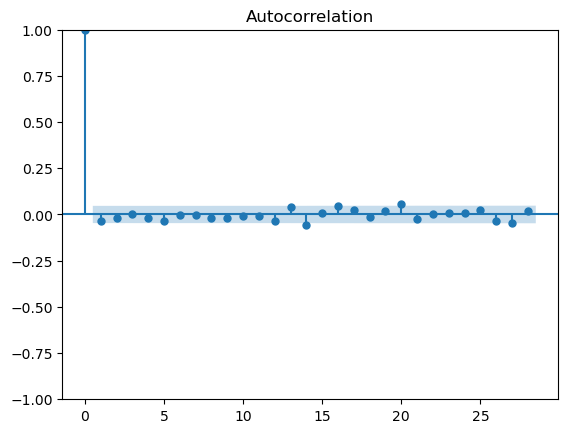

In [33]:
# plot the ACF of the residuals
plot_acf(apple_residuals, lags=28)
plt.show()

From both the ADF test and ACF test, we can conclude that residuals are white noise as they are stationary and have no correlations

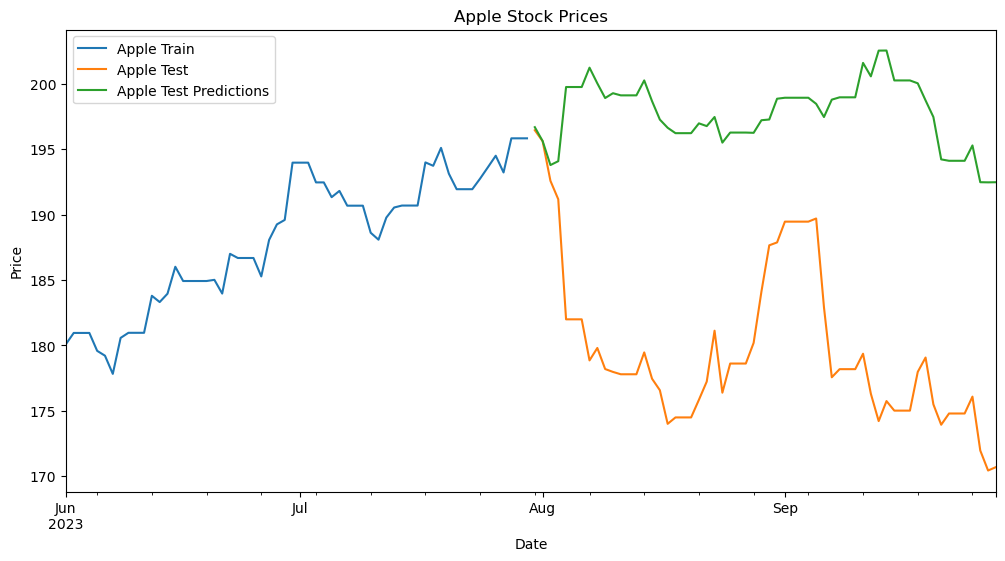

In [34]:
# predict latest 60 days
apple_predictions = best_apple_model.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[['Amazon', 'DBS']]
).rename('Best Apple SARIMAX(0,1,0)(0,0,0,7) Predictions')

# plot for latest 120 days
plt.figure(figsize=(12,6))

train['Apple'].iloc[-60:].plot(label='Apple Train')
test['Apple'].plot(label='Apple Test')
apple_predictions.plot(label='Apple Test Predictions')

plt.title('Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()
plt.show()

In [35]:
apple_rmse_score = rmse(test['Apple'], apple_predictions)
print(f'Root Mean Squared Error of Apple is {apple_rmse_score:.5f}')

Root Mean Squared Error of Apple is 19.12369


##### Amazon

In [36]:
amazon_scores = []

# loop through all possible combinations of p, d, q, P, D, Q, and s
for p in range(0, 3):
    for d in range(1, 2):
        for q in range(0, 3):
            for P in range(0, 3):
                for D in range(0, 1):
                    for Q in range(0, 3):
                        amazon_model = SARIMAX(
                            endog=train['Amazon'],
                            exog=train[['Apple', 'DBS']],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, 7),
                            initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
                            enforce_invertibility=False  # ignores ValueErrors
                        )
                        amazon_results = amazon_model.fit()

                        amazon_scores.append(amazon_results.aic)
                        print(f'ARIMA({p},{d},{q})({P},{D},{Q},7) - AIC: {amazon_results.aic}')

print(f'Lowest AIC score: {min(amazon_scores)}')

ARIMA(0,1,0)(0,0,0,7) - AIC: 7115.422759648801
ARIMA(0,1,0)(0,0,1,7) - AIC: 7193.156390029635
ARIMA(0,1,0)(0,0,2,7) - AIC: 7274.5548663150485
ARIMA(0,1,0)(1,0,0,7) - AIC: 7188.205146342435
ARIMA(0,1,0)(1,0,1,7) - AIC: 7191.499788622716
ARIMA(0,1,0)(1,0,2,7) - AIC: 7276.511465033839
ARIMA(0,1,0)(2,0,0,7) - AIC: 7265.748552536284
ARIMA(0,1,0)(2,0,1,7) - AIC: 7266.1333049729965
ARIMA(0,1,0)(2,0,2,7) - AIC: 7278.264283100916
ARIMA(0,1,1)(0,0,0,7) - AIC: 7127.07293310671
ARIMA(0,1,1)(0,0,1,7) - AIC: 7206.165049569601
ARIMA(0,1,1)(0,0,2,7) - AIC: 7286.306467986228
ARIMA(0,1,1)(1,0,0,7) - AIC: 7188.585352986046
ARIMA(0,1,1)(1,0,1,7) - AIC: 7204.177484887436
ARIMA(0,1,1)(1,0,2,7) - AIC: 7288.149187331933
ARIMA(0,1,1)(2,0,0,7) - AIC: 7266.073740383055
ARIMA(0,1,1)(2,0,1,7) - AIC: 7266.464008962857
ARIMA(0,1,1)(2,0,2,7) - AIC: 7289.743247844583
ARIMA(0,1,2)(0,0,0,7) - AIC: 7140.686861353588
ARIMA(0,1,2)(0,0,1,7) - AIC: 7216.402720558801
ARIMA(0,1,2)(0,0,2,7) - AIC: 7300.642763581722
ARIMA(0,1,2)

In [37]:
best_amazon_model = SARIMAX(
    endog=train['Amazon'],
    exog=train[['Apple', 'DBS']],
    order=(0, 1, 0),
    seasonal_order=(0, 0, 0, 7),
    initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
    enforce_invertibility=False  # ignores ValueErrors
).fit()
print(best_amazon_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Amazon   No. Observations:                 1764
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3554.711
Date:                Fri, 09 Feb 2024   AIC                           7115.423
Time:                        23:36:28   BIC                           7131.849
Sample:                    10-01-2018   HQIC                          7121.492
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.7770      0.013     61.604      0.000       0.752       0.802
DBS            0.0599      0.115      0.522      0.602      -0.165       0.285
sigma2         3.2720      0.034     96.123      0.0

Looking at the diagnostics of the residuals (in the bottom section):
* Ljung-Box test has high p-value => fail to reject H0 of zero autocorrelations => residuals are white-noise
* Heteroskedasticity test has high p-value => fail to reject H0 of homoscedasticity => i.e. residuals are homoscedastic

In [38]:
# check the residuals of the fitted model
amazon_residuals = best_amazon_model.resid
adf_test_resid = adfuller(amazon_residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -17.064397
p-value (residuals): 0.000000


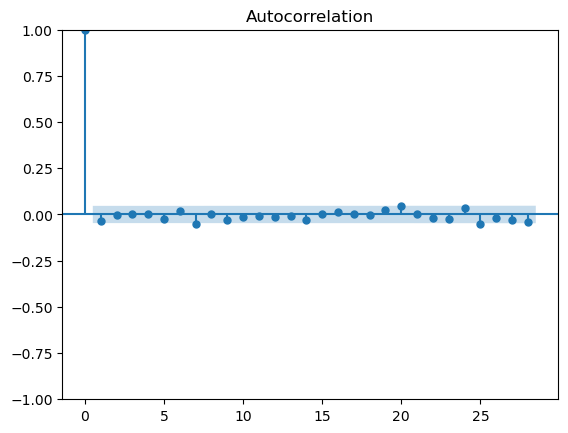

In [39]:
# plot the ACF of the residuals
plot_acf(amazon_residuals, lags=28)
plt.show()

From both the ADF test and ACF test, we can conclude that residuals are white noise as they are stationary and have no correlations

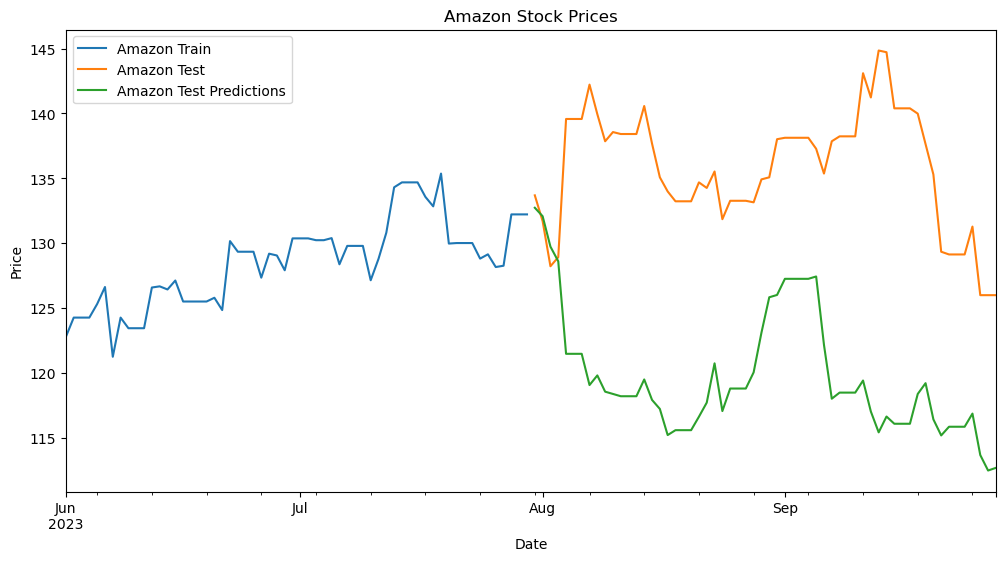

In [40]:
# predict latest 60 days
amazon_predictions = best_amazon_model.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[['Apple', 'DBS']]
).rename('Best Amazon SARIMAX(0,1,0)(0,0,0,7) Predictions')

# plot for latest 120 days
plt.figure(figsize=(12,6))

train['Amazon'].iloc[-60:].plot(label='Amazon Train')
test['Amazon'].plot(label='Amazon Test')
amazon_predictions.plot(label='Amazon Test Predictions')

plt.title('Amazon Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()
plt.show()

In [41]:
amazon_rmse_score = rmse(test['Amazon'], amazon_predictions)
print(f'Root Mean Squared Error of Amazon is {amazon_rmse_score:.5f}')

Root Mean Squared Error of Amazon is 17.36851


##### DBS

In [42]:
dbs_scores = []

# loop through all possible combinations of p, d, q, P, D, Q, and s
for p in range(0, 3):
    for d in range(1, 2):
        for q in range(0, 3):
            for P in range(0, 3):
                for D in range(0, 1):
                    for Q in range(0, 3):
                        dbs_model = SARIMAX(
                            endog=train['DBS'],
                            exog=train[['Apple', 'Amazon']],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, 7),
                            initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
                            enforce_invertibility=False  # ignores ValueErrors
                        )
                        dbs_results = dbs_model.fit()

                        dbs_scores.append(dbs_results.aic)
                        print(f'ARIMA({p},{d},{q})({P},{D},{Q},7) - AIC: {dbs_results.aic}')

print(f'Lowest AIC score: {min(dbs_scores)}')

ARIMA(0,1,0)(0,0,0,7) - AIC: 505.8521218281131
ARIMA(0,1,0)(0,0,1,7) - AIC: 616.3077384472658
ARIMA(0,1,0)(0,0,2,7) - AIC: 724.0444046783855
ARIMA(0,1,0)(1,0,0,7) - AIC: 602.8601955737178
ARIMA(0,1,0)(1,0,1,7) - AIC: 616.3583078538893
ARIMA(0,1,0)(1,0,2,7) - AIC: 726.0108537526921
ARIMA(0,1,0)(2,0,0,7) - AIC: 709.4269382619702
ARIMA(0,1,0)(2,0,1,7) - AIC: 711.1511693547621
ARIMA(0,1,0)(2,0,2,7) - AIC: 723.7261490785604
ARIMA(0,1,1)(0,0,0,7) - AIC: 521.721268053782
ARIMA(0,1,1)(0,0,1,7) - AIC: 632.9268312535746
ARIMA(0,1,1)(0,0,2,7) - AIC: 740.5377621490551
ARIMA(0,1,1)(1,0,0,7) - AIC: 603.8848949831945
ARIMA(0,1,1)(1,0,1,7) - AIC: 633.2332747522554
ARIMA(0,1,1)(1,0,2,7) - AIC: 742.5349419664881
ARIMA(0,1,1)(2,0,0,7) - AIC: 710.1461932855113
ARIMA(0,1,1)(2,0,1,7) - AIC: 711.8660957239352
ARIMA(0,1,1)(2,0,2,7) - AIC: 741.4779610662072
ARIMA(0,1,2)(0,0,0,7) - AIC: 526.4611523999208
ARIMA(0,1,2)(0,0,1,7) - AIC: 637.7359387382555
ARIMA(0,1,2)(0,0,2,7) - AIC: 746.0556077410856
ARIMA(0,1,2)(1

In [43]:
best_dbs_model = SARIMAX(
    endog=train['DBS'],
    exog=train[['Apple', 'Amazon']],
    order=(0, 1, 0),
    seasonal_order=(0, 0, 0, 7),
    initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
    enforce_invertibility=False  # ignores ValueErrors
).fit()
print(best_dbs_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    DBS   No. Observations:                 1764
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -249.926
Date:                Fri, 09 Feb 2024   AIC                            505.852
Time:                        23:40:42   BIC                            522.278
Sample:                    10-01-2018   HQIC                           511.922
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.0048      0.003      1.671      0.095      -0.001       0.010
Amazon         0.0014      0.003      0.539      0.590      -0.004       0.006
sigma2         0.0770      0.001     59.304      0.0

Looking at the diagnostics of the residuals (in the bottom section):
* Ljung-Box test has high p-value => fail to reject H0 of zero autocorrelations => residuals are white-noise
* Heteroskedasticity test has high p-value => fail to reject H0 of homoscedasticity => i.e. residuals are homoscedastic

In [44]:
# check the residuals of the fitted model
dbs_residuals = best_dbs_model.resid
adf_test_resid = adfuller(dbs_residuals)
print('ADF Statistic (residuals): %f' % adf_test_resid[0])
print('p-value (residuals): %f' % adf_test_resid[1])

ADF Statistic (residuals): -12.422097
p-value (residuals): 0.000000


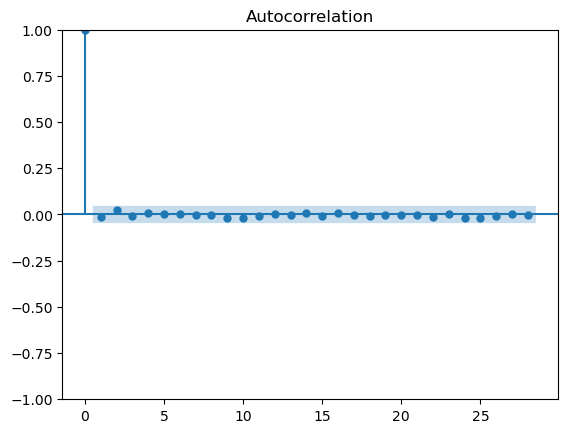

In [45]:
# plot the ACF of the residuals
plot_acf(dbs_residuals, lags=28)
plt.show()

From both the ADF test and ACF test, we can conclude that residuals are white noise as they are stationary and have no correlations

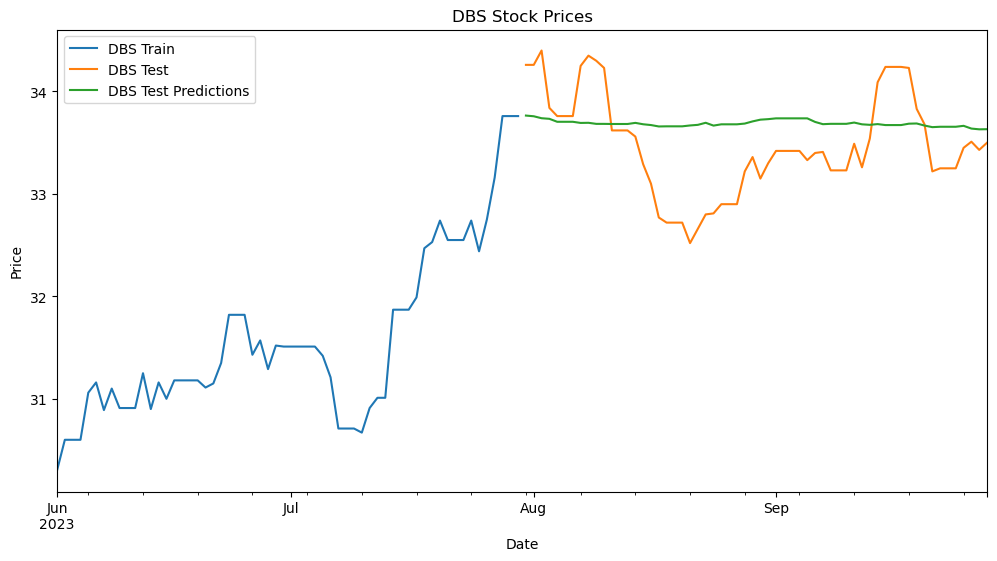

In [46]:
# predict latest 60 days
dbs_predictions = best_dbs_model.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[['Apple', 'Amazon']]
).rename('Best DBS SARIMAX(0,1,0)(0,0,0,7) Predictions')

# plot for latest 120 days
plt.figure(figsize=(12,6))

train['DBS'].iloc[-60:].plot(label='DBS Train')
test['DBS'].plot(label='DBS Test')
dbs_predictions.plot(label='DBS Test Predictions')

plt.title('DBS Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()
plt.show()

In [47]:
dbs_rmse_score = rmse(test['DBS'], dbs_predictions)
print(f'Root Mean Squared Error of DBS is {dbs_rmse_score:.5f}')

Root Mean Squared Error of DBS is 0.52799


## 4. Model Forecasting

As we will not know how accurate our forecasts are, we will use the entire dataset to train the model

### (a) Apple

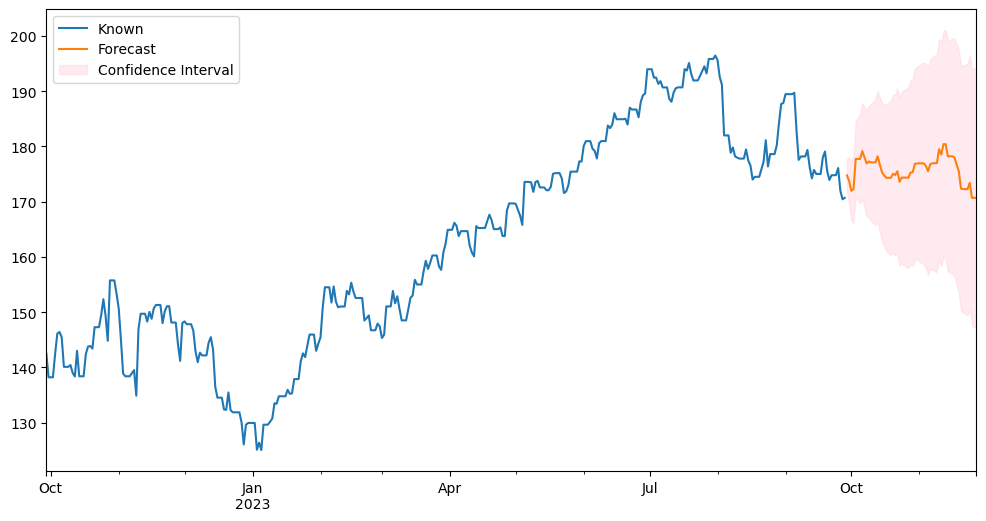

In [48]:
forecast_apple_model = SARIMAX(
    df['Apple'],  # train with entire dataset
    order=(0, 1, 0),
    seasonal_order=(0, 0, 0, 7),
    exog=df[['Amazon', 'DBS']],
    initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
    enforce_invertibility=False  # ignores ValueErrors
).fit()

apple_forecast = forecast_apple_model.get_forecast(steps=60, exog=df[['Amazon', 'DBS']].iloc[-60:])
apple_forecast_values = apple_forecast.predicted_mean
apple_forecast_conf_int = apple_forecast.conf_int()

# plot forecasted values with confidence interval for latest year
plt.figure(figsize=(12, 6))

df['Apple'].iloc[-365:].plot(label='Known')
apple_forecast_values.plot(label='Forecast')
plt.fill_between(
    apple_forecast_values.index,
    apple_forecast_conf_int.iloc[:, 0],
    apple_forecast_conf_int.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

plt.legend(loc='upper left')
plt.show()

In [49]:
print(apple_forecast_values)

2023-09-29    174.759315
2023-09-30    173.735211
2023-10-01    171.963963
2023-10-02    172.245589
2023-10-03    177.720291
2023-10-04    177.720291
2023-10-05    177.720291
2023-10-06    179.152836
2023-10-07    177.993523
2023-10-08    176.910935
2023-10-09    177.266490
2023-10-10    177.103669
2023-10-11    177.103669
2023-10-12    177.103669
2023-10-13    178.206844
2023-10-14    176.676517
2023-10-15    175.311818
2023-10-16    174.704545
2023-10-17    174.306411
2023-10-18    174.306411
2023-10-19    174.306411
2023-10-20    175.029688
2023-10-21    174.828055
2023-10-22    175.501286
2023-10-23    173.608857
2023-10-24    174.352261
2023-10-25    174.352261
2023-10-26    174.352261
2023-10-27    174.335428
2023-10-28    175.265975
2023-10-29    175.318838
2023-10-30    176.852893
2023-10-31    176.926347
2023-11-01    176.926347
2023-11-02    176.926347
2023-11-03    176.926347
2023-11-04    176.476285
2023-11-05    175.503171
2023-11-06    176.786000
2023-11-07    176.956285


### (b) Amazon

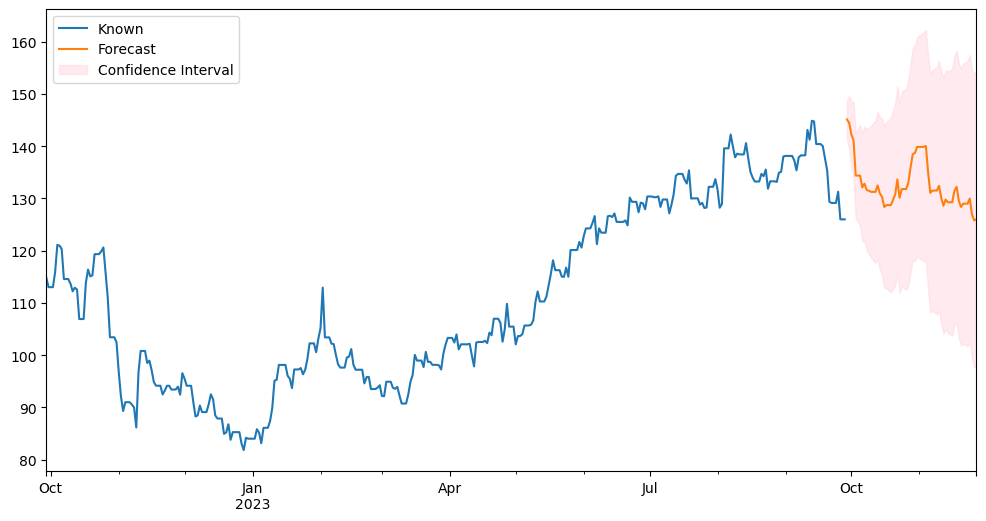

In [50]:
forecast_amazon_model = SARIMAX(
    df['Amazon'],
    order=(0, 1, 0),
    seasonal_order=(0, 0, 0, 7),
    exog=df[['Apple', 'DBS']],
    initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
    enforce_invertibility=False  # ignores ValueErrors
).fit()

amazon_forecast = forecast_amazon_model.get_forecast(steps=60, exog=df[['Apple', 'DBS']].iloc[-60:])
amazon_forecast_values = amazon_forecast.predicted_mean
amazon_forecast_conf_int = amazon_forecast.conf_int()

# plot forecasted values with confidence interval for latest year
plt.figure(figsize=(12, 6))

df['Amazon'].iloc[-365:].plot(label='Known')
amazon_forecast_values.plot(label='Forecast')
plt.fill_between(
    amazon_forecast_values.index,
    amazon_forecast_conf_int.iloc[:, 0],
    amazon_forecast_conf_int.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

plt.legend(loc='upper left')
plt.show()

In [51]:
print(amazon_forecast_values)

2023-09-29    145.103606
2023-09-30    144.482625
2023-10-01    142.257409
2023-10-02    141.156009
2023-10-03    134.361119
2023-10-04    134.361119
2023-10-05    134.361119
2023-10-06    132.091477
2023-10-07    132.804319
2023-10-08    131.608829
2023-10-09    131.438811
2023-10-10    131.241435
2023-10-11    131.241435
2023-10-12    131.241435
2023-10-13    132.469695
2023-10-14    130.955301
2023-10-15    130.284725
2023-10-16    128.350020
2023-10-17    128.706993
2023-10-18    128.706993
2023-10-19    128.706993
2023-10-20    129.683913
2023-10-21    130.726251
2023-10-22    133.616753
2023-10-23    130.113693
2023-10-24    131.771741
2023-10-25    131.771741
2023-10-26    131.771741
2023-10-27    132.973514
2023-10-28    135.893583
2023-10-29    138.481054
2023-10-30    138.659505
2023-10-31    139.847596
2023-11-01    139.847596
2023-11-02    139.847596
2023-11-03    139.847596
2023-11-04    140.015526
2023-11-05    135.003294
2023-11-06    131.049270
2023-11-07    131.488637


### (c) DBS

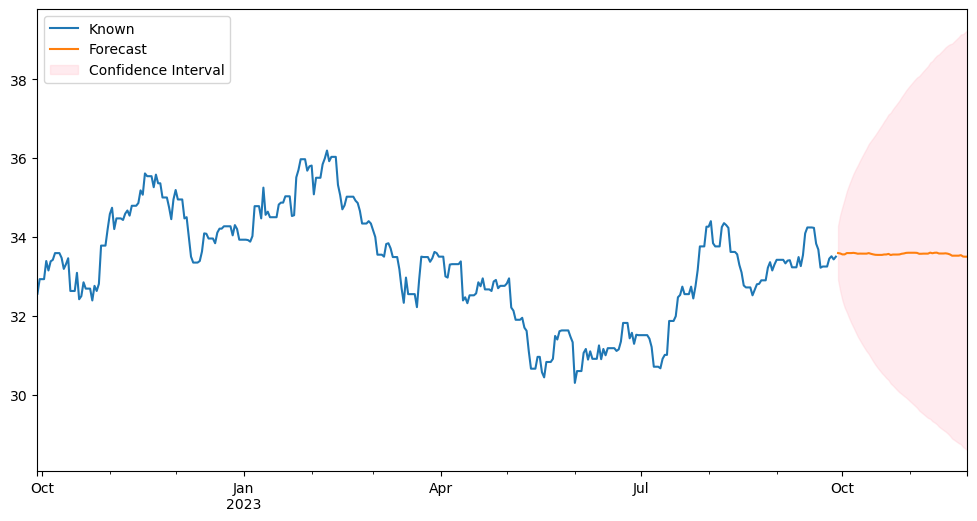

In [52]:
forecast_dbs_model = SARIMAX(
    np.log(df['DBS']),
    order=(0, 1, 0),
    seasonal_order=(0, 0, 0, 7),
    exog=np.log(df[['Apple', 'Amazon']]),
    initialization='approximate_diffuse',  # assumes a high level of uncertainty in the initial state of the model
    enforce_invertibility=False  # ignores ValueErrors
).fit()

dbs_forecast = forecast_dbs_model.get_forecast(steps=60, exog=np.log(df[['Apple', 'Amazon']].iloc[-60:]))
dbs_forecast_values = dbs_forecast.predicted_mean
dbs_forecast_conf_int = dbs_forecast.conf_int()
dbs_forecast_values_antilog = np.exp(dbs_forecast_values)

# plot forecasted values with confidence interval for latest year
plt.figure(figsize=(12, 6))

df['DBS'].iloc[-365:].plot(label='Known')
dbs_forecast_values_antilog.plot(label='Forecast')
plt.fill_between(
    dbs_forecast_values_antilog.index,
    np.exp(dbs_forecast_conf_int.iloc[:, 0]),
    np.exp(dbs_forecast_conf_int.iloc[:, 1]),
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

plt.legend(loc='upper left')
plt.show()

In [53]:
print(dbs_forecast_values)

2023-09-29    3.514276
2023-09-30    3.513937
2023-10-01    3.513241
2023-10-02    3.513264
2023-10-03    3.514256
2023-10-04    3.514256
2023-10-05    3.514256
2023-10-06    3.514426
2023-10-07    3.514172
2023-10-08    3.513778
2023-10-09    3.513864
2023-10-10    3.513832
2023-10-11    3.513832
2023-10-12    3.513832
2023-10-13    3.514238
2023-10-14    3.513706
2023-10-15    3.513280
2023-10-16    3.512958
2023-10-17    3.512879
2023-10-18    3.512879
2023-10-19    3.512879
2023-10-20    3.513177
2023-10-21    3.513203
2023-10-22    3.513630
2023-10-23    3.512797
2023-10-24    3.513146
2023-10-25    3.513146
2023-10-26    3.513146
2023-10-27    3.513228
2023-10-28    3.513727
2023-10-29    3.513963
2023-10-30    3.514394
2023-10-31    3.514505
2023-11-01    3.514505
2023-11-02    3.514505
2023-11-03    3.514505
2023-11-04    3.514399
2023-11-05    3.513717
2023-11-06    3.513738
2023-11-07    3.513831
2023-11-08    3.513831
2023-11-09    3.513831
2023-11-10    3.514578
2023-11-11 

The reason why the DBS prediction is quite linear is because the seasonal pattern of the series (shown in ETS Decompostition) is really small in magnitude compared to the other stocks, hence the seasonality pattern does not have much influence in the prediction of the model